# Do some imports

In [1]:
from typing import List
import numpy as np
import pandas as pd
#!pip install --user pandas

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

from dataloader import UNSW_NB15

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option("display.precision",30)


### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [ ]:
# define NN architecture
class Net(nn.Module):
    
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.relu2 = nn.ReLU()

        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.relu3 = nn.ReLU()

        
        self.out = nn.Linear(hidden3, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        a1 = self.fc1(x)
        #b1 = self.batchnorm1(a1)
        h1 = self.relu1(a1)
        dout1 = self.dout(h1)
        
        a2 = self.fc2(dout1)
        #b2 = self.batchnorm2(a2)
        h2 = self.relu2(a2)
        dout2 = self.dout(h2)
        
        a3 = self.fc3(dout2)
        #b3 = self.batchnorm3(a3)
        h3 = self.relu3(a3)
        dout3 = self.dout(h3)
        
        a4= self.out(dout3)
        y = self.sigmoid(a4)
        return y

### Define Train,   Test   and    Display_Loss_Plot    methods

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        
        optimizer.zero_grad()
        
        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        #inputs, target = inputs.to(device), target.to(device)
        
        #FORWARD PASS
        output = model(inputs.float())

        loss = criterion(output, target.unsqueeze(1))
        #import pdb; pdb.set_trace()
        
        #BACKWARD AND OPTIMIZE
        
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [ ]:
#TESTING THE MODEL
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # the model on the data
            output = model(inputs.float())
                       
            #PREDICTIONS
            pred = np.round(output)
            #pred = output.detach().numpy() > 0.5 
            pred = pred * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [ ]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Define some parameters first

In [ ]:
device = 'cpu'
input_size = 196      # 42 for integer encoding 196
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 1000  #500 1000 100 100
batch_size = 500   #100 1000 100 500  
lr = 0.01          #0.01 0.01 0.005 0.1

# Initialize Neural Network class

In [ ]:
model = Net(input_size, hidden1, hidden2, hidden3, num_classes)

# Define loss and optimizer 

In [ ]:
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Initialize UNSW_NB15 class

In [ ]:
#these are not slitted into validation and train set
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Lets Train, Test the model and see the loss

In [ ]:
running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_loader, optimizer,criterion)
        running_loss.append(loss_epoch)

In [ ]:
test(model,device,test_loader)

In [ ]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Results

    num_epochs = 200
    batch_size = 8000 
    lr = 0.001
    accuracy on test set = 0.7572389836272653
<img src="data/loss_function_75.723898_acc.PNG">

---------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------

# Quntization

#### Define some needed methods

In [2]:
def get_list_output_sep_list(list_:list,index_values:list):
    #assert len(list_[0]) == 594, f"Each element of the list has has the wrong size len(a)={len(a)}, len(b)={len(b)}"
    tmp_list= []
    for current_i in index_values:   
        if current_i != 26:
            tmp_list.append(list_[0][previous_i:current_i])
        else:          
            tmp_list.append(list_[0][0:current_i])
        previous_i=current_i
    return tmp_list
#get_list_output_sep_list(["000000000000000000000010110111011100000101000000000000100000000000000000000000000000011111000000000000000000000000000000001110101101000101100101011111111110000000000000010011110100100000001111100011000000000000000000000000000000000000000000000000000000000000000000000000001011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000001001000000100000100000100000100000000000000000100001000"],index_values)

def sep_array_several_columns(array:np.ndarray, column_bit_position:list):
    #receives the binfeat and separates everything and transforms it into decimal
    #receives a list of binary rows, all values of each row are concatenated together. THis method separates them,
    #transofrms them to datframe and then converts to decimal
    index=['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label']
    df_decimal=pd.DataFrame()
    index_values = [el[1] for el in column_bit_position]
    for ix in range(array.shape[0]):
        row_list = []
        series = pd.Series(get_list_output_sep_list(array[ix],index_values), index=index)
        df_decimal = df_decimal.append(series, ignore_index=True)
        
    for column in df_decimal.columns:
        df_decimal[column] = df_decimal[column].astype(str).apply(lambda x: format(int(x,2)))
    return df_decimal

#df_binfeat_decimal = sep_array_several_columns(binfeat[0:4], column_bit_position)

In [3]:
def bar_plot(dictionary: dict, x_label, y_label, title):
    fig = plt.figure(figsize = (10, 5)) 

    plt.bar(list(dictionary.keys()),  list(dictionary.values()) ) 

    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(title) 
    plt.show() 

In [4]:
def check_diff(a : str, b : str) -> List[int]:
    """
    return the positions where a != b
    """
    result = []
    assert len(a) == len(b), f"the two strings must have equal size. len(a)={len(a)}, len(b)={len(b)}"
    
    for i in range(len(a)):
        if a[i] != b[i]:
            result.append(i)
    return result

def multi_check_diff(A,B):
    assert A.shape == B.shape, f"Both matrices must match in shape. A shape is {A.shape}, B shape is {B.shape}"
    
    all_diffs = []
    for i in range(A.shape[0]):
        all_diffs.append(check_diff(A[i][0], B[i][0]))
    return all_diffs

#all_diffs = multi_check_diff(binfeat, binarized_dataset_concated)

In [5]:
def belongs_to_column(num : int, col_positions : List[List]):
    """
    given any index position, returns the column that contains the bit of that position.
    """
    for i in range(len(col_positions)):
        if num < col_positions[i][1]:
            return col_positions[i]

# test -> should return rate, 148
#assert belongs_to_column(147, column_bit_position) == ['rate', 148], "Function is failing"

def error_row_column_distribution(all_diffs : List[List], col_positions : List[List]):
    """
    For each row, counts the errors of each column. 
    One or more errors per row for the same column are counted as just +1
    """
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        row_column_errors = []
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            if column in row_column_errors:
                continue
            row_column_errors.append(column)
            
            if column not in count_dictionary:
                count_dictionary[column] = 1
            else:
                count_dictionary[column] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    return sorted_count
#sorted_count = error_row_column_distribution(all_diffs, column_bit_position)
#bar_plot( sorted_count, x_label="Columns", y_label="Rows with Errors", title="Error distribution on rows")

def error_bit_column_distribution(all_diffs : List[List], col_positions : List[List]):
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            
            if column not in count_dictionary:
                count_dictionary[column] = 1
            else:
                count_dictionary[column] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    
    return sorted_count

#sorted_count = error_bit_column_distribution(all_diffs, column_bit_position)
#bar_plot( sorted_count, x_label="Columns", y_label="Total Amount of Errors", title="Total amount of errors that each column has") 

def error_bit_position_distribution(all_diffs : List[List], col_positions : List[List]):
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            position_counting_from_last = last_pos - diff - 1
            
            if position_counting_from_last not in count_dictionary:
                count_dictionary[position_counting_from_last] = 1
            else:
                count_dictionary[position_counting_from_last] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    return sorted_count
#sorted_count = error_bit_position_distribution(all_diffs, column_bit_position)
#bar_plot( sorted_count, x_label="Bit position: 0-last, ...", y_label="Total Amount of Errors", title="Which bit is being more errored: the last bit") 



In [6]:
def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('Pyhton', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

def get_highlight_diff(df1,df2):
    df_all = pd.concat([df1, df2], 
                       axis='columns', keys=['Pyhton', 'Matlab'])
    df_final = df_all.swaplevel(axis='columns')[df1.columns[1:]]
    return df_final.style.apply(highlight_diff, axis=None)

#get_highlight_diff(tmp_df.reset_index(drop=True).loc[500:1000,:],df_binfeat_decimal.reset_index(drop=True).loc[500:1000,:])

In [7]:
def round_like_matlab_number(n):
    """Round the input "n" like matlab uint32(n) cast (which also rounds) 0.5->1;  1.5->2; 2.3->2;   2.45->2 """
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)
#assert round_like_matlab_number(0.5) == 1 , "THis is workig properly"

def round_like_matlab_series(series:pd.Series)->pd.Series:
    rounded_values_list = []
    for value in series:
        rounded_values_list.append(round_like_matlab_number(value))
    return pd.Series(rounded_values_list) 
#round_like_matlab_series(pd.Series([0.49999999999999999, 1.5 , 2.5, 3.5, 4.5]))

In [8]:
from sklearn import preprocessing
def integer_encoding(df_):
    df = df_.copy()
    """Applies integer encoding to the object columns of the dataframe"""
    le = preprocessing.LabelEncoder()
    
    for column in df.select_dtypes('object').columns.tolist():
        df[column] = le.fit_transform(df[column])
    return df

In [9]:
# adapted from here https://stackoverflow.com/questions/51471097/vectorized-conversion-of-decimal-integer-array-to-binary-array-in-numpy
def dec2bin(column: pd.Series, number_of_bits: int, left_msb:bool= True )-> pd.Series: 
    """Convert a decimal pd.Series to binary pd.Series with numbers in their base-2 equivalents.
    The output is a numpy nd array.   
    # adapted from here https://stackoverflow.com/questions/51471097/vectorized-conversion-of-decimal-integer-array-to-binary-array-in-numpy

    Parameters
    ----------
     column: pd.Series
        Series wit all decimal numbers that will be cast to binary
     number_of_bits: str
        The desired number of bits for the binary number. If bigger than what is needed then those bits will be 0.
        The number_of_bits should be >= than what is needed to express the largest decimal input 
     left_msb: bool
        Specify that the most significant digit is the leftmost element. If this is False, it will be the rightmost element.
    Returns
    -------
    numpy.ndarray
       Numpy array with all elements in binary representation of the input.
        
    """
 
    my_binary_repr = lambda number, nbits:  np.binary_repr(number, nbits)[::-1]
    func = my_binary_repr if left_msb else np.binary_repr
 
    return np.vectorize(func)(column.values, number_of_bits)

# Create Python dataset (Integer and Quantized)

In [11]:
#---
train = pd.read_csv('data/UNSW_NB15_training-set.csv', sep = ",")
test = pd.read_csv('data/UNSW_NB15_testing-set.csv', sep = ",")

df = pd.concat([test,train])
skip_cols = ['id','attack_cat'] #this is what they have


#----
df_encoded = integer_encoding(df)
#----

# gets the smallest positive number of a vector
get_min_positive_number = lambda vector: vector[vector > 0].min()
# computes the maximum required bits to represent eachs number from a vector of numbers
get_max_bits = lambda vector: math.ceil(math.log2(float(vector.max())+1.0))

python_quantized_df = pd.DataFrame(columns= df_encoded.columns) # final matrix of bit vetors
first_iteration = True

python_quantized_df = df_encoded.copy().drop(columns=skip_cols)
total_bits = 0
column_bit_position = []
python_float_df = pd.DataFrame()
python_uint32_df = pd.DataFrame()

for column in python_quantized_df.columns:       
    column_data = df_encoded[column]
    
    m = get_min_positive_number(column_data)
    m_inv = 1.0/m    
    if m_inv>1:
        column_data = column_data * np.float64(m_inv)
        
    python_float_df[column] = pd.Series(column_data)      
    column_bit_position.append([column, total_bits])
    
    maxbits = get_max_bits(column_data)
    total_bits += maxbits  
    
    #CLIP, ROUND and CAST to UINT32
    column_data = np.clip(column_data, 0, 4294967295)  #clip 
    column_data = round_like_matlab_series(column_data)       #round like matlab
    column_data = column_data.astype(np.uint32)         #cast like matlab
    
    python_uint32_df[column] = pd.Series(column_data)
    
    binary_vector = dec2bin(column_data, maxbits, left_msb=False).reshape((-1,1))
    python_quantized_df[column] = binary_vector.flatten()
    
#Merge all the columns
python_quantized_df_concated = python_quantized_df.apply(''.join, axis=1).to_frame()

In [12]:
# This is PYTHON float dataset
python_float_df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,11.0,119,0,5,2,0,496,0,61675095.11533242464065551757812500,254,0,332530659.277245223522186279296875,0.0,0,0,11.00000000000000177635683940025,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,8.0,119,0,5,2,0,1762,0,84803256.64857529103755950927734375,254,0,1624271520.675814867019653320312500,0.0,0,0,8.00000000000000000000000000000,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0


In [13]:
# This is PYTHON uint32 dataset
python_uint32_df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,11,119,0,5,2,0,496,0,61675095,254,0,332530659,0,0,0,11,0,0,0,0,0,0,0,0,0,0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,8,119,0,5,2,0,1762,0,84803257,254,0,1624271521,0,0,0,8,0,0,0,0,0,0,0,0,0,0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0


In [14]:
# This is PYTHON quantized dataset
python_quantized_df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,00000000000000000000001011,01110111,0000,0101,00000000000010,00000000000000,000000000000000111110000,000000000000000000000000,000011101011010001011001010111,11111110,00000000,0000010011110100100000001111100011,0000000000000000000000000,0000000000000,0000000000000,000000000000000000000001011,00000000000000000000000000,0000000000000000000000000000000,00000000000000000000000000,00000000,00000000000000000000000000000000,00000000000000000000000000000000,00000000,00000000000000,0000000000000,0000000000000000,00011111000,00000000000,00000000,00000000000000000000000,000010,010,000001,000001,000001,0000010,000,000,00000,000001,000010,0,0
1,00000000000000000000001000,01110111,0000,0101,00000000000010,00000000000000,000000000000011011100010,000000000000000000000000,000101000011011111111010111001,11111110,00000000,0001100000110100000110101010100001,0000000000000000000000000,0000000000000,0000000000000,000000000000000000000001000,00000000000000000000000000,0000000000000000000000000000000,00000000000000000000000000,00000000,00000000000000000000000000000000,00000000000000000000000000000000,00000000,00000000000000,0000000000000,0000000000000000,01101110001,00000000000,00000000,00000000000000000000000,000010,010,000001,000001,000001,0000010,000,000,00000,000001,000010,0,0


# Get Matlab datasets (Float, UINT32 and Quantized)

In [26]:
#get MATLAB float df 
matlab_float_df = pd.read_csv('matlab_float_df.csv',header=None, float_precision = 'round_trip')

# Process it - drop columns and reorganize them
matlab_float_df = matlab_float_df.drop(columns = [0,43])
matlab_float_df.columns = python_float_df.columns.tolist()

matlab_float_df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,11.0,119.0,0.0,5.0,2.0,0.0,496.0,0.0,61675095.11533242464065551757812500,254.0,0.0,332530659.277245223522186279296875,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
1,8.0,119.0,0.0,5.0,2.0,0.0,1762.0,0.0,84803256.64857529103755950927734375,254.0,0.0,1624271520.675814867019653320312500,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,881.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0


In [27]:
#get MATLAB UINT32 df
matlab_uint32_df = pd.read_csv("matlab_uint32_df.csv", header=None)

# Process it
matlab_uint32_df = matlab_uint32_df.drop(columns = [0,43])
matlab_uint32_df.columns = python_uint32_df.columns.tolist()

matlab_uint32_df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,11,119,0,5,2,0,496,0,61675095,254,0,332530659,0,0,0,11,0,0,0,0,0,0,0,0,0,0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,8,119,0,5,2,0,1762,0,84803257,254,0,1624271521,0,0,0,8,0,0,0,0,0,0,0,0,0,0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0


In [28]:
#get MATLAB quantized dataset
matlab_quantized_df_concated = pd.read_csv('matlab_quantized_df_concated.csv',header=None) #this only has 1 big column

#Process it
"""
matlab_quantized_dataset = sep_array_several_columns(matlab_quantized_df_concated.values[0:200], column_bit_position) #separate by columns
matlab_quantized_dataset = matlab_quantized_dataset.astype(np.int64)
"""

matlab_quantized_df_concated.head(2)

,0
0,0000000000000000000000101101110111000001010000...
1,0000000000000000000000100001110111000001010000...


# Lets check for the differences
    TOTAL ROW NUMBER = 257 673

In [37]:
# Check how many different rows are in each dfs: float64, uint32, quantized
print("Comparing python and matlab Float64 dfs... Number of diferent rows are=",\
      (python_float_df.values != matlab_float_df.values).sum())
print("Comparing python and matlab UINT32 dfs... Number of diferent rows are=", \
      (python_uint32_df.values != matlab_uint32_df.values).sum())
print("Comparing python and matlab quantized dfs... Number of diferent rows are=", \
      (python_quantized_df_concated.values != matlab_quantized_df_concated.values).sum())

Comparing python and matlab Float64 dfs... Number of diferent rows are= 353781
Comparing python and matlab UINT32 dfs... Number of diferent rows are= 14
Comparing python and matlab quantized dfs... Number of diferent rows are= 14


In [47]:
# Check ...
print(" The highest difference between float dfs is =", \
      np.max(abs((python_float_df.values - matlab_float_df.values))))
print(" The highest difference between uint32 dfs is =",\
      np.max(abs((python_uint32_df.values - matlab_uint32_df.values))))

print("(Note that there are 14 rows different) The amount of differences between the uint32 dfs all summed is equal=", \
      np.sum(abs((python_uint32_df.values - matlab_uint32_df.values))))

 The highest difference between float dfs is = 2.384185791015625e-07
 The highest difference between uint32 dfs is = 1
(Note that there are 14 rows different) The amount of differences between the uint32 dfs all summed is equal= 14


In [53]:
print("Clip function has been well done...", np.where(python_uint32_df > 4294967295))

Clip function has been well done... (array([], dtype=int64), array([], dtype=int64))


In [54]:
#where are the quantized dfs different?
index = np.where(matlab_quantized_df_concated.reset_index(drop=True) != python_quantized_df_concated.reset_index(drop=True))[0]

#where is that in the floating point df
#python_uint32_df.iloc[index]

#highlight differences
get_highlight_diff(python_uint32_df.iloc[index],matlab_uint32_df.iloc[index])

#### Lets plot some things to see the differences

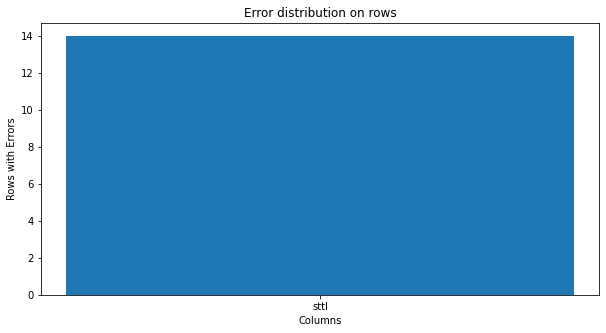

In [55]:
all_diffs = multi_check_diff(matlab_quantized_df_concated.values, python_quantized_df_concated.values)
sorted_count = error_row_column_distribution(all_diffs, column_bit_position)
bar_plot( sorted_count, x_label="Columns", y_label="Rows with Errors", title="Error distribution on rows")


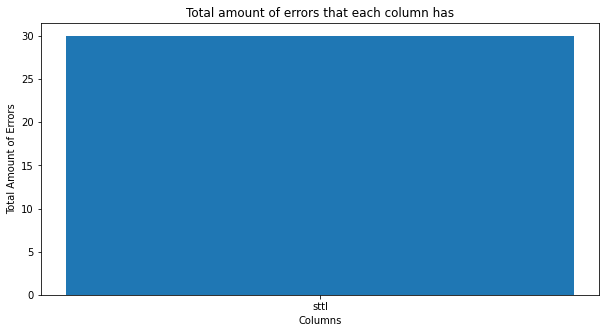

In [56]:
all_diffs = multi_check_diff(matlab_quantized_df_concated.values, python_quantized_df_concated.values)
sorted_count = error_bit_column_distribution(all_diffs, column_bit_position)
bar_plot( sorted_count, x_label="Columns", y_label="Total Amount of Errors", title="Total amount of errors that each column has") 


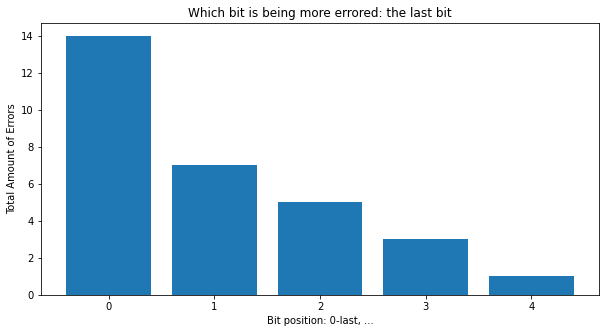

In [57]:
all_diffs = multi_check_diff(matlab_quantized_df_concated.values, python_quantized_df_concated.values)
sorted_count = error_bit_position_distribution(all_diffs, column_bit_position)
bar_plot( sorted_count, x_label="Bit position: 0-last, ...", y_label="Total Amount of Errors", title="Which bit is being more errored: the last bit") 
